### importing and formatting data

In [70]:
#import packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import csv
import seaborn as sns
from gpmap import GenotypePhenotypeMap
from epistasis.models import *
from epistasis.stats import *
from epistasis import *
from epistasis.pyplot import plot_power_transform, plot_coefs
from epistasis.pyplot.nonlinear import plot_scale
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import scipy.stats as st
from sklearn.metrics import r2_score

plt.rcParams.update({'font.size': 7,'axes.linewidth':0.5,
                     'xtick.major.size':2,'xtick.major.width':0.5,
                    'ytick.major.size':2,'ytick.major.width':0.5})
plt.rcParams.update({'mathtext.default':  'regular' })


colorH1, colorH3, colorFluB, colorH9 = "#E8735C", "#72C2A6", "#5482A7", "#663399"



In [94]:
#arbitrary params
#choose between local (wt) and global (geo mean) origins for data
#origin = "local" 
origin = 'global'

if origin == 'local':
    ep_type = 'biochem'
elif origin == 'global':
    ep_type = 'stat'

# choose type of nonlinear function
#function = 'power'
#function = 'spline'
function = 'logistic'

# antigen='H1'
# antigen_column='h1_mean'
antigen='H9'
antigen_column='h9_mean'

In [95]:
#import data
df_data = pd.read_csv('../../../CR6261/Kd_meanbin/kd_processed/20210323_6261_HA_unadj_fil_merg.csv',dtype={"variant": str})
print(len(df_data))

df = df_data.dropna(subset=[antigen_column])
print(len(df))



1917
1842


In [96]:
# fit linear model to original phenotypes
genos = np.array(df[['pos1','pos2','pos3','pos4','pos5','pos6','pos7','pos8','pos9','pos10','pos11']].copy(),dtype=np.float64)
phenos = df[[antigen_column]].values.flatten()

if ep_type == 'stat':
    genos = 2.0*genos-1.0

poly_linear = PolynomialFeatures(1,interaction_only=True)
genos_linear = poly_linear.fit_transform(genos)

raw_reg_linear = sm.OLS(phenos, genos_linear).fit()
raw_reg_coefs_linear = raw_reg_linear.params
print(raw_reg_linear.params)

pred_phenos_linear = raw_reg_linear.predict(genos_linear)


[ 8.72769696  0.44052997  0.51132258  0.01861066 -0.03481862  0.03965673
  0.52055521  0.27835278 -0.05558475  0.19073559  0.14823244  0.08817711]


In [82]:
def logistic(x,A,B,mu,sigma):
    return A*(1-(1/(1+np.exp((x-mu)/sigma))))+B

def logistic_inverse(xadd,y,param_list):
    A,B,mu,sigma = param_list
    yvals = np.array(y)
    maxval = logistic(np.max(xadd),A,B,mu,sigma)
    above_indices = np.where(yvals > maxval)[0]
    yvals_trimmed = np.where(yvals > maxval,maxval,yvals)
    inv = sigma*np.log(1/(1-((yvals_trimmed-B)/A))-1)+mu
    return inv
    
    

In [97]:
#format training and test sets for epistasis package

wildtype = "00000000000"



#training gpm
gpm_data = GenotypePhenotypeMap(
    wildtype,
    genotypes=df['variant'],
    phenotypes=df[antigen_column], model_type=origin)




# fit nonlinear transform

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
<ipython-input-98-921687c6873c>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['linearized_pheno'] = linearized_phenotypes.tolist()


0.8457744002583418
odict_values([<Parameter 'A', value=3.1137730408982147 +/- 0.0689, bounds=[-inf:inf]>, <Parameter 'B', value=6.6918087139756945 +/- 0.0527, bounds=[-inf:inf]>, <Parameter 'mu', value=8.244623369073675 +/- 0.0204, bounds=[-inf:inf]>, <Parameter 'sigma', value=0.45122887844697673 +/- 0.0185, bounds=[-inf:inf]>])


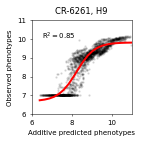

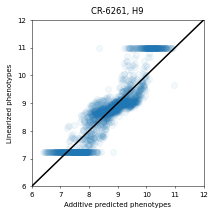

In [98]:
# Initialize the model

if function == 'power':
    func = EpistasisPowerTransform(lmbda=1, A=0, B=0, model_type=origin)
    num_params = 3
elif function == 'spline':
    num_params = 6
    func = EpistasisSpline(k=num_params-1, model_type=origin)
elif function == 'logistic':
    num_params = 4
    func = EpistasisLogisticTransform(A=4,B=7,mu=8,sigma=1, model_type=origin)

func.add_gpm(gpm_data)


# Fit the model.
func.fit()

# Transform Pobs to Pobs,linearized via nonlinear function
params = []
for i in func.parameters.values():
    params.append(i.value)

if function == 'logistic':
    linearized_phenotypes = logistic_inverse(pred_phenos_linear,phenos,params)
elif function == 'power':
    linearized_phenotypes = power_inverse(pred_phenos_linear,phenos,params)
    
    
df['linearized_pheno'] = linearized_phenotypes.tolist()

print(func.score())
print(func.parameters.values())


fig, ax = plt.subplots(figsize=(2,2))
plot_scale(func, ax=ax,alpha=0.1,s=2)
ax.set_xlim([6,11])
ax.set_ylim([6,11])
ax.set_xlabel("Additive predicted phenotypes")
ax.set_ylabel("Observed phenotypes")
plt.title('CR-6261, '+antigen)
plt.text(6.5,10,f'$R^2 = {func.score():.2f}$')
plt.tight_layout()
plt.savefig('images/6261_'+antigen+'_'+function+str(num_params)+'_transformation.pdf')
plt.show()



## Fit linear interaction models to transformed data

In [99]:
# format geno and pheno data
genos = np.array(df[['pos1','pos2','pos3','pos4','pos5','pos6','pos7','pos8','pos9','pos10','pos11']].copy(),dtype=np.float64)
phenos_pred = df[['linearized_pheno']].values.flatten()

if ep_type == 'stat':
    genos = 2.0*genos-1

vals = np.where(~np.isnan(phenos_pred))[0]
genos = genos[vals]
phenos_pred = phenos_pred[vals]

# set parameters for CV
max_order = 6
num_folds = 10

# lists to store r squared values
rsq_train_list = np.zeros((max_order+1,num_folds))
rsq_test_list = np.zeros((max_order+1,num_folds))

size_test = int(float(1/num_folds)*len(genos))


# loop over CV folds
for f in range(num_folds):

    # get train & test sets
    start = int(f*size_test)
    stop = int((f+1)*size_test)
    genos_train = np.concatenate((genos[:start],genos[stop:]))
    genos_test = genos[start:stop]
    phenos_train = np.concatenate((phenos_pred[:start],phenos_pred[stop:]))
    phenos_test = phenos_pred[start:stop]
    
    print('Fold: ',f)
    
    # initialize zero-order (intercept-only) model
    genos_train_previous = np.full(len(genos_train),1.0)
    genos_test_previous = np.full(len(genos_test),1.0)

    reg_previous = sm.OLS(phenos_train,genos_train_previous).fit()
    reg_coefs_previous = reg_previous.params

    rsquared_train_previous = reg_previous.rsquared
    rsquared_test_previous = 1-np.sum((phenos_test-reg_previous.predict(genos_test_previous))**2)/np.sum((phenos_test-np.mean(phenos_test))**2)
    rsq_train_list[0,f] = rsquared_train_previous
    rsq_test_list[0,f] = rsquared_test_previous

    mean_pheno_train = np.mean(phenos_train)
    mean_pheno_test = np.mean(phenos_test)


    # fit models of increasing order
    for order in range(1,max_order+1):
        #print('Order: ',str(order))
        poly_current = PolynomialFeatures(order,interaction_only=True)
        genos_train_current = poly_current.fit_transform(genos_train)
        genos_test_current = poly_current.fit_transform(genos_test)

        reg_current = sm.OLS(phenos_train, genos_train_current).fit()
        reg_coefs_current = reg_current.params
        reg_CIs_current = reg_current.conf_int(alpha=0.05, cols=None)
        reg_stderr = reg_current.bse
    
        rsquared_train_current = reg_current.rsquared
        rsquared_test_current = 1-np.sum((phenos_test-reg_current.predict(genos_test_current))**2)/np.sum((phenos_test-np.mean(phenos_test))**2)
        rsq_train_list[order,f] = rsquared_train_current
        rsq_test_list[order,f] = rsquared_test_current
        

# average over folds
mean_rsq_train = np.mean(rsq_train_list,axis=1)
stdev_rsq_train = np.std(rsq_train_list,axis=1)
mean_rsq_test = np.mean(rsq_test_list,axis=1)
stdev_rsq_test = np.std(rsq_test_list,axis=1)

optimal_order = np.argmax(mean_rsq_test)
print('Optimal order: ',optimal_order)


Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Fold:  6
Fold:  7
Fold:  8
Fold:  9
Optimal order:  3


In [100]:
# fit final models & write to file


mutations = [str(x) for x in np.arange(1,12)]

# loop through orders
for order in range(1,optimal_order+1):
    
    print('Order: ',str(order))
    poly_current = PolynomialFeatures(order,interaction_only=True)
    genos_current = poly_current.fit_transform(genos)

    # fit
    reg_current = sm.OLS(phenos_pred,genos_current).fit()
    reg_coefs_current = reg_current.params
    reg_CIs_current = reg_current.conf_int(alpha=0.05/float(len(reg_coefs_current)), cols=None)
    reg_stderr = reg_current.bse
    reg_pvalues = reg_current.pvalues

    predicted_phenos_permuted = reg_current.predict(genos_current)
    rsquared_current = reg_current.rsquared
    print('Params: ',len(reg_coefs_current))
    print('Performance: ',rsquared_current)
     
    # write model to file
    if order == optimal_order:
        coef_names = poly_current.get_feature_names(input_features = mutations)
        with open('model_coefs/globalep_6261_'+antigen+'_'+function+str(num_params)+'_'+str(order)+'order_'+ep_type+'.txt','w') as writefile:
            coef_writer = csv.writer(writefile,delimiter='\t')
            coef_writer.writerow(['Nonlinear function type: ',function])
            for i in func.parameters.values():
                coef_writer.writerow([i.name,i.value])
            coef_writer.writerow(['Nonlinear function performance: ',func.score()])
            coef_writer.writerow(['Params: ',len(reg_coefs_current)])
            coef_writer.writerow(['Performance: ',rsquared_current])
            coef_writer.writerow(['Term','Coefficient','Standard Error','p-value','95% CI lower','95% CI upper'])
            coef_writer.writerow(['Intercept',reg_coefs_current[0]])
            for i in range(1,len(reg_coefs_current)):
                coef_writer.writerow([','.join(coef_names[i].split(' ')),reg_coefs_current[i],reg_stderr[i],
                                  reg_pvalues[i],reg_CIs_current[i][0],reg_CIs_current[i][1]])
            writefile.close()


Order:  1
Params:  12
Performance:  0.8231525222190093
Order:  2
Params:  67
Performance:  0.8995042316528714
Order:  3
Params:  232
Performance:  0.9335704800259464
